In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import requests
from io import BytesIO
import requests
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:

# obtener clave
api_key = os.getenv("GOOGLE_FONT_API_KEY")

url = f"https://www.googleapis.com/webfonts/v1/webfonts?key={api_key}"

# descargar JSON
response = requests.get(url)
raw_json = response.json()

df = pd.DataFrame(raw_json["items"])
df.head()


,family,variants,subsets,version,lastModified,files,category,kind,menu,colorCapabilities
0,ABeeZee,"[regular, italic]","[latin, latin-ext]",v23,2025-09-08,{'regular': 'https://fonts.gstatic.com/s/abeez...,sans-serif,webfonts#webfont,https://fonts.gstatic.com/s/abeezee/v23/esDR31...,NaN
1,ADLaM Display,[regular],"[adlam, latin, latin-ext]",v1,2025-05-30,{'regular': 'https://fonts.gstatic.com/s/adlam...,display,webfonts#webfont,https://fonts.gstatic.com/s/adlamdisplay/v1/KF...,NaN
2,AR One Sans,"[regular, 500, 600, 700]","[latin, latin-ext, vietnamese]",v6,2025-09-16,{'regular': 'https://fonts.gstatic.com/s/arone...,sans-serif,webfonts#webfont,https://fonts.gstatic.com/s/aronesans/v6/TUZez...,NaN
3,Abel,[regular],[latin],v18,2025-05-30,{'regular': 'https://fonts.gstatic.com/s/abel/...,sans-serif,webfonts#webfont,https://fonts.gstatic.com/s/abel/v18/MwQ5bhbm2...,NaN
4,Abhaya Libre,"[regular, 500, 600, 700, 800]","[latin, latin-ext, sinhala]",v18,2025-09-16,{'regular': 'https://fonts.gstatic.com/s/abhay...,serif,webfonts#webfont,https://fonts.gstatic.com/s/abhayalibre/v18/e3...,NaN


In [3]:
cols = ['family', 'variants', 'subsets', 'category', 'files']
df = df[cols]

df.head()

,family,variants,subsets,category,files
0,ABeeZee,"[regular, italic]","[latin, latin-ext]",sans-serif,{'regular': 'https://fonts.gstatic.com/s/abeez...
1,ADLaM Display,[regular],"[adlam, latin, latin-ext]",display,{'regular': 'https://fonts.gstatic.com/s/adlam...
2,AR One Sans,"[regular, 500, 600, 700]","[latin, latin-ext, vietnamese]",sans-serif,{'regular': 'https://fonts.gstatic.com/s/arone...
3,Abel,[regular],[latin],sans-serif,{'regular': 'https://fonts.gstatic.com/s/abel/...
4,Abhaya Libre,"[regular, 500, 600, 700, 800]","[latin, latin-ext, sinhala]",serif,{'regular': 'https://fonts.gstatic.com/s/abhay...


In [4]:
characters = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
IMG_WIDTH = 100
IMG_HEIGHT = 100


In [5]:
def drawCharacter(digit, font_url, font_size=70): 
    
    # Descargamos la fuente
    response = requests.get(font_url)
    font = ImageFont.truetype(BytesIO(response.content), font_size)
    
    # Imagen fondo blanco
    img = Image.new("L", (IMG_WIDTH, IMG_HEIGHT), color=255)
    draw = ImageDraw.Draw(img)

    # Tamaño real del caracter -> (left, top, right, bottom)

    bbox = draw.textbbox((0, 0), digit, font=font)

    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]

    # Centrado del texto
    x = (IMG_WIDTH - text_w) // 2 - bbox[0]
    y = (IMG_HEIGHT - text_h) // 2 - bbox[1]

    # Dibujamos el numero
    draw.text((x, y), digit, fill=0, font=font)

    return img, np.array(img)


In [6]:
row = df[df.family == "Abel"].iloc[0]
font_url = row["files"]["regular"]
font_url


'https://fonts.gstatic.com/s/abel/v18/MwQ5bhbm2POE6VhLPJp6qGI.ttf'

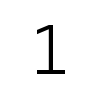

In [7]:
img, arr = drawCharacter("1", font_url)
img
